# XAS Workflow Task 2

This notebook contains the second task of the XAS processing workflow. 

The break up of the task consist of the following steps 

|Task                            | Input                                         | Output
|-------------                   |-------------                                  |-----  
| Curve fitting||
| 1. Import data                |File: FeS2_larch.prj                              |
| 2. Import Crystal data        |File: FeS2.inp                                 |
| 3. Calculate Paths(Atoms+FEFF)||
| 4. Set path parameters        | Parameters:                                   |
|                                 |    amp  = 1                                   |
|                                 |    enot = 0                                   |
|                                 |    delr = 0                                   |
|                                 |    ss   = 0.003                               |
| 5. Select paths                 |                                               |
| 6. Run Fit                    |                                               |
| 7. Save project               ||
| 8. Verify fit results         ||
| 8.1 If not OK revise parameners and refit (go to 2.4)||
| 8.2 If OK Save project and outputs|                                           |File: FeS2_01.fpj

For more details about larch, see https://xraypy.github.io/xraylarch/xafs/


## Libraries
Libraries required for running fit on the XAS data.


In [1]:
# managing athena files
from larch.io import create_athena, read_athena, extract_athenagroup
# calculate pre-edge and post edge for normalisation
from larch.xafs import pre_edge
# perform background removal
from larch.xafs import autobk
# calculate fourier transform
from larch.xafs import xftf



from larch import Interpreter
import larch_plugins as lp

# File handling
from pathlib import Path

#plotting library
%matplotlib inline
import matplotlib.pyplot as plt

# subprocess library used to run perl script
import subprocess

#library for writing to log
import logging


# Library with the functions that handle athena files
import lib.manage_athena as athenamgr  

# Library with the functions that execute 
# Atoms and FEFF to generate scattering paths
import lib.atoms_feff as feff_runner   

# Set parameters          
# library containign functions tho manage fit, at read, write 
# GDS parameters, and scattering paths. 
import lib.manage_fit as fit_manager  



session = Interpreter()

## Custom Functions

The following cell contains the defined functions (methods) for processing XAS files.

- **set_logger** intialises the logging.
- **get_files_list** returns a list of files in the directory matching the given file pattern.
- **calc_with_defaults ** recalculates mu, normal, pre-edge for each group being processed.
    


In [2]:
 #######################################################
# |                Initialise log file                | #
# V  provide the path and name of the log file to use V #
 #######################################################
    
def set_logger(log_file):
    logger = logging.getLogger()
    fhandler = logging.FileHandler(filename=log_file, mode='a')
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fhandler.setFormatter(formatter)
    logger.addHandler(fhandler)
    # prevent matplotlib font manager from writing to log
    logging.getLogger('matplotlib.font_manager').disabled = True
    logger.setLevel(logging.DEBUG)

 #######################################################
# |                  Get a list of files              | #
# V       provide the path and pattern to match       V #
 #######################################################
    
#reading all files with the same extension files from a dir
def get_files_list(source_dir, f_pattern):
    i_counter = 0
    files_list = []
    for filepath in sorted(source_dir.glob(f_pattern)):
        i_counter += 1
        files_list.append(filepath)
    return files_list




## Input parameters (variables)

The variables in the next cell indicate where to get the data from, the pattern of the files to process and the number of files to process. These can be changed to process different datasets.


In [3]:
# variables that can be changed to process different datasets
data_path = ".\\rh4co\\"
file_pattern = "*.prj"
f_prefix = "rh4co"
crystal_files = ["..\\cif_files\\C12O12Rh4.cif"] #"FeS2.inp"
gds_parms_f = "rh4co40_gds.csv"
sel_paths_f = "rh4co40_sp.csv"
top_count = 4 # limit the number of files processed 
show_graph = True # False to prevent showing graphs

# variables for fit
fit_vars = {}
fit_vars['fitspace']='r'
fit_vars['kmin']=3 
fit_vars['kmax']=14
fit_vars['kw']=2 
fit_vars['dk']=1
fit_vars['window']='hanning'
fit_vars['rmin']=1.4
fit_vars['rmax']=3.0

In [4]:
# read save parameters from input gds file
gds = fit_manager.read_gds(gds_parms_f, session)
# show gsd group parameters in a spreadsheet
this_sheet = fit_manager.show_gds(gds)
# save gsd group parameters in a csv file
fit_manager.save_gds(gds, gds_parms_f)

Sheet(cells=(Cell(column_start=0, row_end=21, row_start=0, squeeze_column=False, squeeze_row=False, value=[['i…

## Main function
The code in the cell below performs the bulk of the processing for task 2 calling functions defined above and using the input parameters.

The three operations for generating paths, selecting paths and defining parameters are performed once before processing the input files in the list

### Generate paths 
Larch does larch does not include a means for running **Atoms**. Atoms is needed to get input for **FEFF** and calculate paths. Currently, the fastest option is to run Artemis to obtain the input (.inp) file for FEFF from a crystal file ('.cif' or '.inp').

The run_feff function, defined above, uses the subprocess library to call perl to execute a script that runs Artemis Atoms, and saves the output file ('.inp') in a new directory. The file is then be used to run FEFF from Larch to calculate scattering paths.

### Select paths and set parameters
Select paths and set parameters are tasks which can be performed for the first fit  and then reused for all following datasets.  

#### Set Parameters

The read_gds function, defined above, creates the parameters group (GDS in Artemis) from a gds file. The code uses lp.fitting.param_group and lp.fitting.param instead of importing Group and Parameter (does not work with Jupyter). The parameter values are read from a text file.

#### Select Paths
The selection of scattering paths is handled by the read_paths function. Each scattering path is loaded while setting the amplitude, $\Delta E_0$, $\Delta R$ and $\sigma^2$ parameters using the GDS parameters defined previously. The groups are then added returned as a list of paths to be used for the fits.


rh4co_fit\process.log


[root] INFO : Started processing
[root] INFO : Input variables:
[root] INFO : 	data_path    = .\rh4co\
[root] INFO : 	file_pattern = *.prj
[root] INFO : 	f_prefix     = rh4co
[root] INFO : 	crystal_files = ['..\\cif_files\\C12O12Rh4.cif']
[root] INFO : 	top_count    = 4


 : ======== running Feff module C:\Users\scman1\Anaconda3\envs\python36\lib\site-packages\larch\bin\win32\feff6l.exe ========
 : Feff 6L.02
 : Rh4 (C O)12
 : Wei, C.H.
 : Structural analyses of tetracobalt dodecacarbonyl and tetrarhodium
 : dodecacarbonyl. crystallographic treatments of a disordered structure and
 : a twinned composite
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : free atom potential and density for atom type    3
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : overlapped potential and density for unique potential    3
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique

[root] INFO : Completed FEFF
[root] INFO : GDS Parameters read OK


 : 114     5.096     1.000     4   4.9712
 : 115     6.492     1.000     2   4.9766
 : 94 paths kept,  115 examined.
 : Feff done.  Have a nice day.


[root] INFO : Selected Paths read OK


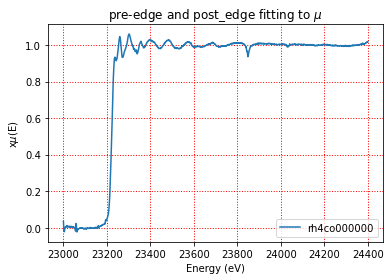

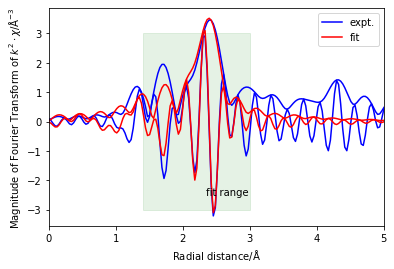

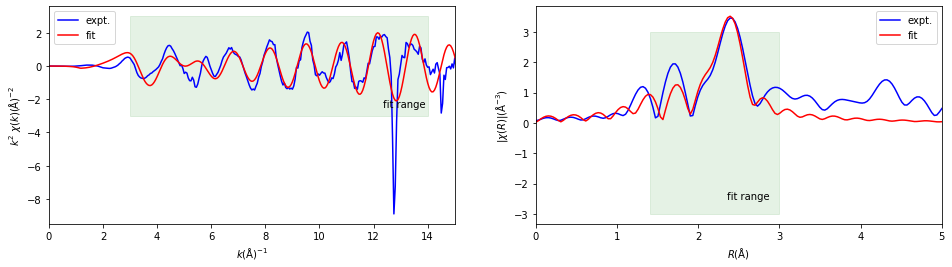

[root] INFO : Processed file: 1 rh4co000000
[root] INFO : GDS Parameters read OK
[root] INFO : Selected Paths read OK


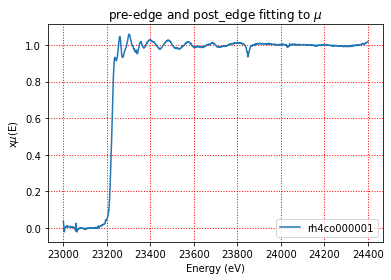

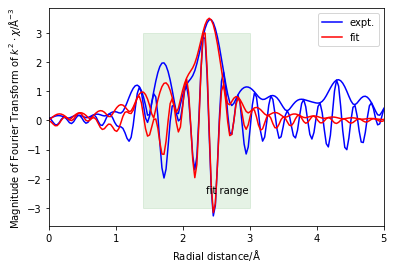

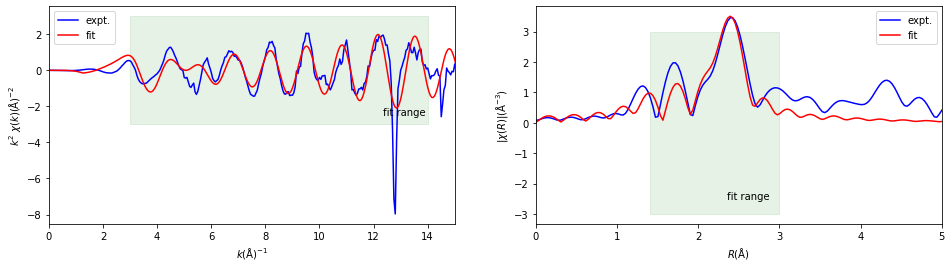

[root] INFO : Processed file: 2 rh4co000001
[root] INFO : GDS Parameters read OK
[root] INFO : Selected Paths read OK


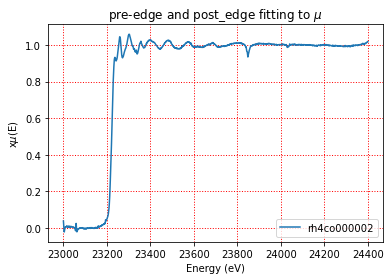

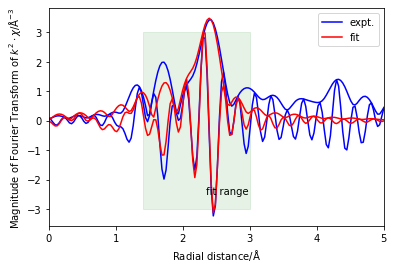

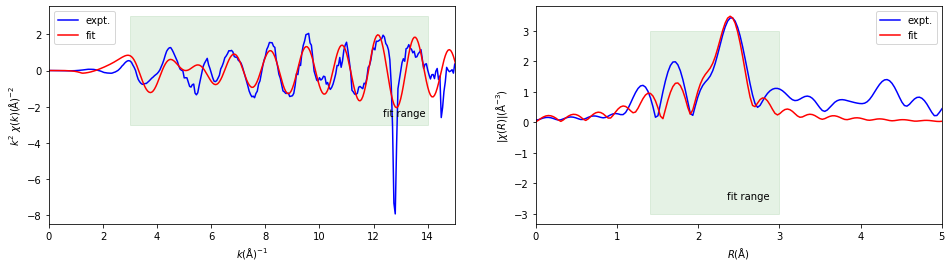

[root] INFO : Processed file: 3 rh4co000002
[root] INFO : GDS Parameters read OK
[root] INFO : Selected Paths read OK


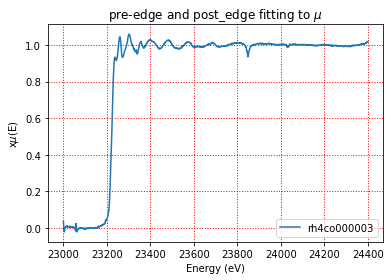

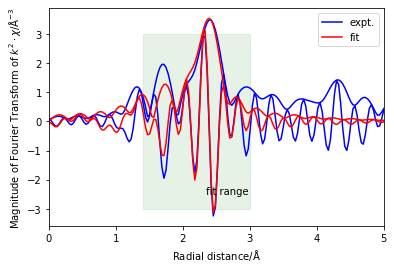

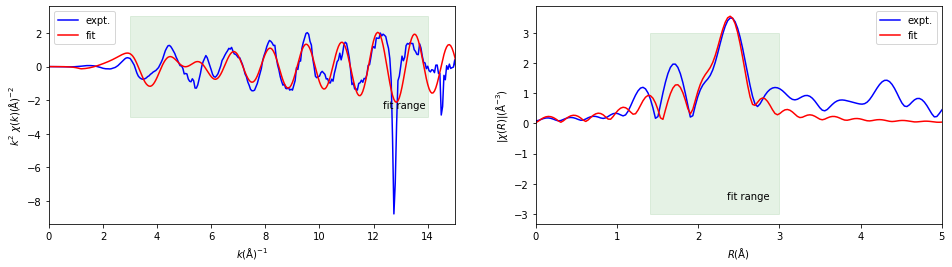

[root] INFO : Processed file: 4 rh4co000003
[root] INFO : Finished processing


In [6]:
# create the path for storing results
base_path = Path("./" , f_prefix+"_fit")
Path(base_path).mkdir(parents=True, exist_ok=True)

log_file = Path("./",base_path,"process.log")
print(log_file)
# set path for log
set_logger(log_file)

# get the list of files to process
source_path = Path(data_path)
files_list = get_files_list(source_path, file_pattern)
xas_data = {}

logging.info("Started processing")
logging.info("Input variables:")
logging.info("\tdata_path    = " + data_path)
logging.info("\tfile_pattern = " + file_pattern)
logging.info("\tf_prefix     = " + f_prefix)
logging.info("\tcrystal_files = " + str(crystal_files))
logging.info("\ttop_count    = " + str(top_count))



# run feff on crystal file to generate scattering paths
feff_runner.run_feff(crystal_files)
logging.info("Completed FEFF")


# counter for break
i_count = 0
for a_file in files_list:
    
    # read the gds parameters from input file
    gds = fit_manager.read_gds(gds_parms_f, session)
    logging.info("GDS Parameters read OK")
    project_name = a_file.name
    data_prj = read_athena(a_file)
    group_keys = list(data_prj._athena_groups.keys())
    athena_group = extract_athenagroup(data_prj._athena_groups[group_keys[0]])
    # recalculate norm, background removal and fourier transform 
    # with defaults
    data_group = athenamgr.calc_with_defaults(athena_group)

    # read the selected paths list to access relevant paths 
    # generated from FEFF
    selected_paths = fit_manager.read_selected_paths_list(sel_paths_f, session)
    logging.info("Selected Paths read OK")
    # run fit
    trans, dset, out = fit_manager.run_fit(data_group, gds, selected_paths, fit_vars, session)
    
    
    if show_graph:    
        # plot normalised mu on energy
        # plot mu vs flat normalised mu for selected groups
        #plt, data_group = plot_Nxmu_E(data_prj, group_keys, group_names)
        plt = athenamgr.plot_normalised(data_group)
        plt.show()
        # Overlaped 𝜒(𝑘) and 𝜒(𝑅) plots (similar to Demeter's Rmr plot)
        
        rmr_p = fit_manager.plot_rmr(dset,fit_vars['rmin'],fit_vars['rmax'])
        rmr_p.show()
        
        # Separate 𝜒(𝑘) and 𝜒(𝑅) plots 
        chikr_p = fit_manager.plot_chikr(dset,fit_vars['rmin'],fit_vars['rmax'],fit_vars['kmin'],fit_vars['kmax'])
        chikr_p.show()
    

    #save the fit report to a text file
    fit_file = Path("./",base_path,group_keys[0]+"_fit_rep.txt")
    fit_manager.save_fit_report(out, fit_file, session)

    i_count +=1
    
    logging.info("Processed file: "+ str(i_count) +" " + group_keys[0])
    

    
    if i_count == top_count:
        break
       
logging.info("Finished processing")

#### Things to do
- for manual task
 - ~Allow setting parameters interactively (if CSV file does not exist or is missing)~
 - ~Move all functions to libraries (hide complexity from researchers)~
 - ~Test running with textbook example (FeS2)~
 - ~Test running with sample data (Rh4CO12)~
- for batch processing
 - ~replicate in batch processing (reading of parameters and paths)~
 - ~test run automatic with textbook example~
 - test run automatic with sample data (Rh4CO)